# Symulowane wyżarzanie
## Laboratorium 4 - Metody Obliczeniowe w Nauce i Technice

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import copy
from enum import Enum
from itertools import permutations

## Zadanie 1. Problem komiwojażera.

Wygeneruj chmurę $n$ losowych punktów w 2D, a następnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów.

In [4]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __str__(self):
        return f"Point({self.x}, {self.y})"
    
    @staticmethod
    def print_1d(array): 
        print("[", end='')
        for p in array: 
            print(p, end=", ")
        print("\b\b]")
    
    @staticmethod
    def print_2d(array): 
        print("[")
        for row in array:
            Point.print_1d(row)
        print("]")
        

def generate_point_arrays(n):
    P = []
    normal_parameters = [(4, 2), (8, 8), (0, 6), (512, 64)]
    
    # List of point tuples: first is bottom left, second is upper right corner of a region
    group_point_regions = [
        (Point(0, 0), Point(1, 1)),
        (Point(2, 0), Point(3, 1)),
        (Point(4, 0), Point(5, 1)),
        (Point(0, 2), Point(1, 3)),
        (Point(2, 2), Point(3, 3)),
        (Point(4, 2), Point(5, 3)),
        (Point(0, 5), Point(1, 6)),
        (Point(2, 4), Point(3, 5)),
        (Point(5, 5), Point(6, 6))
    ]
    m = len(group_point_regions)
    
    # Uniform distribution
    P.append([Point(np.random.randint(0, 2 * n**0.5), np.random.randint(0, 2 * n**0.5)) for _ in range(n)])
    
    # Normal distribution (4 different set of parameters)
    for l, s in normal_parameters:
        x = np.random.normal(l, s, n)
        y = np.random.normal(l, s, n)
        P.append([Point(x[i], y[i]) for i in range(n)])
        
    # 9 group of points
    x = np.random.uniform(group_point_regions[0][0].x, group_point_regions[0][1].x, n // m + n % m)
    y = np.random.uniform(group_point_regions[0][0].y, group_point_regions[0][1].y, n // m + n % m)
    for i in range(1, m):
        x = np.concatenate((x, np.random.uniform(group_point_regions[i][0].x, group_point_regions[i][1].x, n // m)))
        y = np.concatenate((y, np.random.uniform(group_point_regions[i][0].y, group_point_regions[i][1].y, n // m)))
    P.append([Point(x[i], y[i]) for i in range(n)])
    
    return np.array(P)


def draw_point_array(P, path=None):
    fig, ax = plt.subplots()
    if path is not None:
        ax.plot([path[i % len(path)].x for i in range(len(path) + 1)], [path[i % len(path)].y for i in range(len(path) + 1)], c="#3c4440", zorder=0)
    ax.scatter([p.x for p in P], [p.y for p in P], s=72, c="#29ea8f", zorder=1)

    plt.show()

    
def draw_point_arrays(P):
    for row in P:
        draw_point_array(row)


# P = generate_point_arrays(10)
# draw_point_arrays(P)

In [5]:
class NeighbourSelection(Enum):
    CONSECUTIVE_SWAP = 0,
    ARBITRARY_SWAP = 1


class SimulatedAnnealing:
    def __init__(self, initial_solution, gamma, initial_T, max_iterations, neighbour_selection):
        self.initial_solution = initial_solution
        self.gamma = gamma
        self.T = initial_T
        self.max_iterations = max_iterations
        self.neighbour_selection = neighbour_selection
        
    def run(self):
        state, state_cost = copy.deepcopy(self.initial_solution), self.get_cost(self.initial_solution)
        solution, solution_cost = copy.deepcopy(self.initial_solution), self.get_cost(self.initial_solution)
        
        for i in range(self.max_iterations):
            if self.T <= 10**-2:
                break

            new_state = self.neighbour(state)
            new_state_cost = self.get_cost(new_state)

            if self.P(new_state_cost, state_cost) >= np.random.uniform(0, 1):
                state, state_cost = new_state, self.get_cost(new_state)
                if self.get_cost(state) < self.get_cost(solution):
                   solution, solution_cost = copy.deepcopy(state), state_cost
                
        return solution, solution_cost
    
    def distance(self, p1, p2):
        return ((p2.x - p1.x)**2 + (p2.y - p1.y)**2)**.5 
    
    def get_cost(self, state):
        acc = 0.0
        for i, j in [(i, (i + 1) % len(state)) for i in range(len(state))]:
            acc += self.distance(state[i], state[j])
            
        return acc
        
    def neighbour(self, state):
        state = state.copy()
        
        if self.neighbour_selection.ARBITRARY_SWAP:
            i, j = np.random.default_rng().choice(len(state), 2)
        else:
            i = np.random.default_rng().choice(len(state))
            j = (i + 1) % len(state)
        
        state[i], state[j] = state[j], state[i]
        
        return state
        
    def P(self, new_state_cost, state_cost):
        if new_state_cost < state_cost:
            return 1
        return np.exp((state_cost - new_state_cost) / self.T)
    

a) Wizualizacja rozwiązań dla 3 różnych wartości $n$ oraz 3 różnych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema
różnymi grupami parametrów, dziewięć odseparowanych grup punktów)

$n = 8$

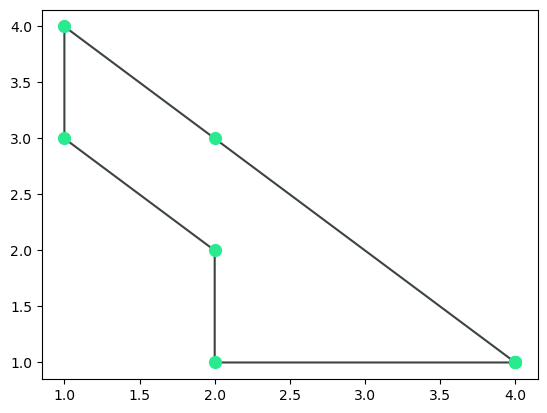

Total distance: 9.6569





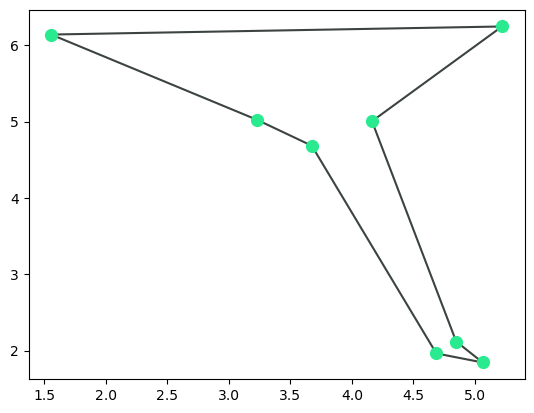

Total distance: 14.4818





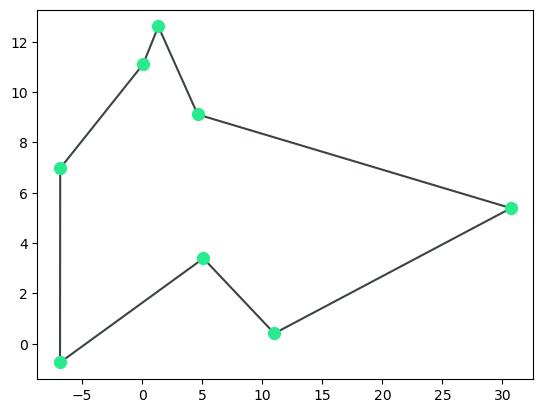

Total distance: 88.4521





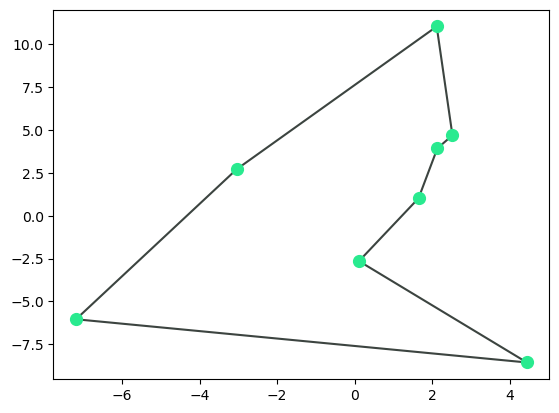

Total distance: 52.887





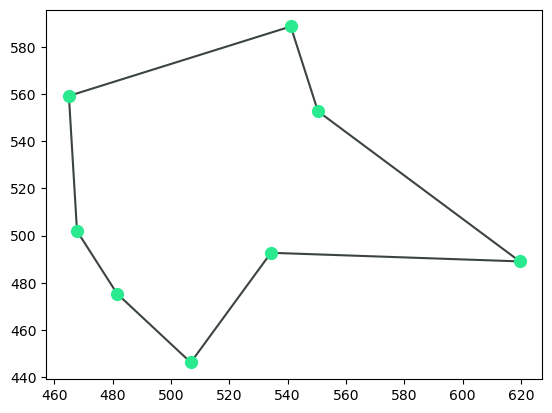

Total distance: 477.9791





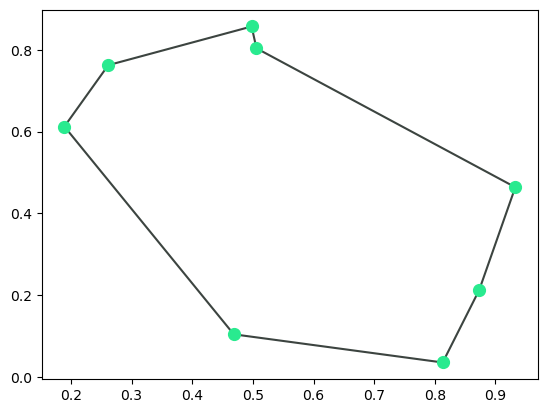

Total distance: 2.3963





In [7]:
for p in generate_point_arrays(2**3):
    res, total_distance = SimulatedAnnealing(p, .95, 2**10, 20000, NeighbourSelection.ARBITRARY_SWAP).run()
    draw_point_array(p, res)
    print(f"Total distance: {round(total_distance, 4)}", end="\n\n\n\n")

$n = 32$

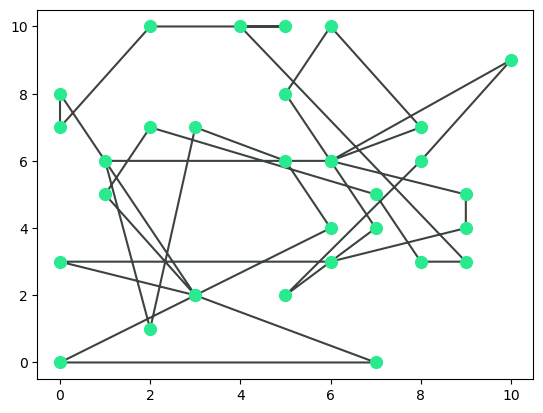

Total distance: 123.1867





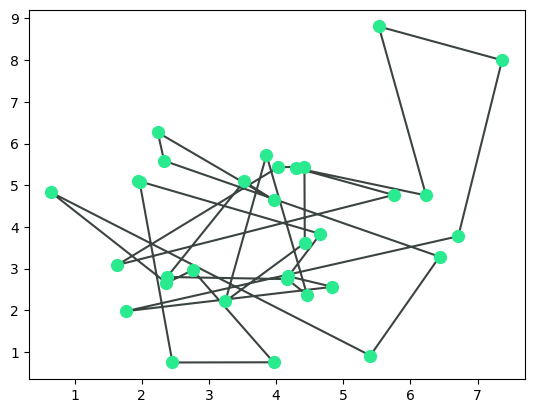

Total distance: 79.7092





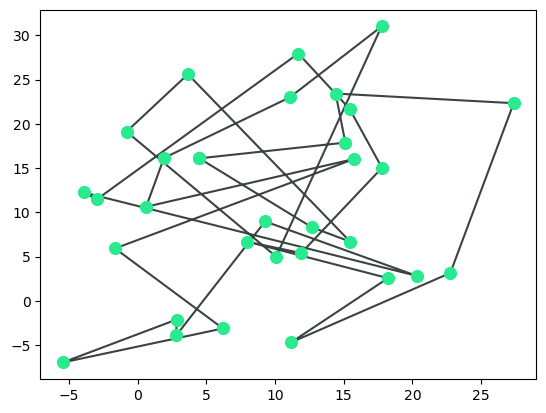

Total distance: 379.6521





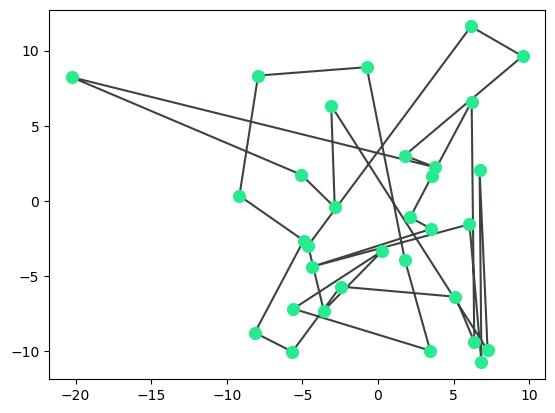

Total distance: 276.7081





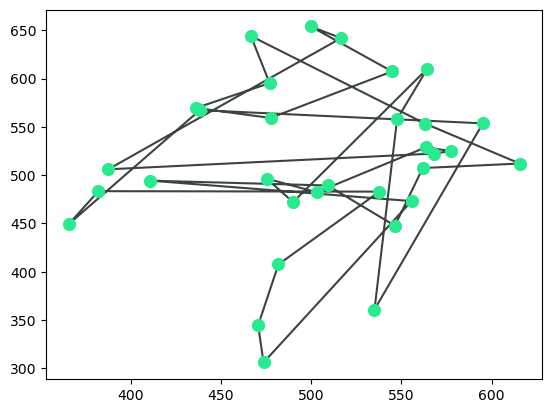

Total distance: 2934.6984





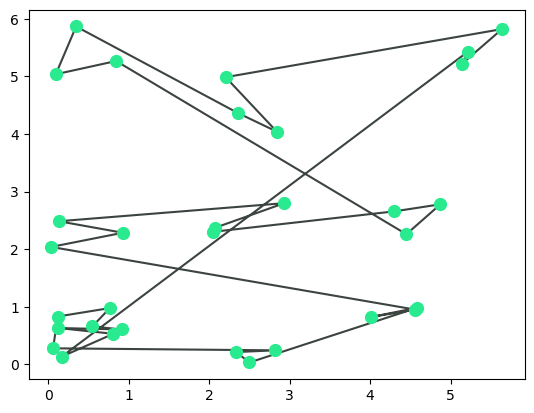

Total distance: 47.381





In [8]:
for p in generate_point_arrays(2**5):
    res, total_distance = SimulatedAnnealing(p, .95, 2**10, 20000, NeighbourSelection.ARBITRARY_SWAP).run()
    draw_point_array(p, res)
    print(f"Total distance: {round(total_distance, 4)}", end="\n\n\n\n")

$n = 128$

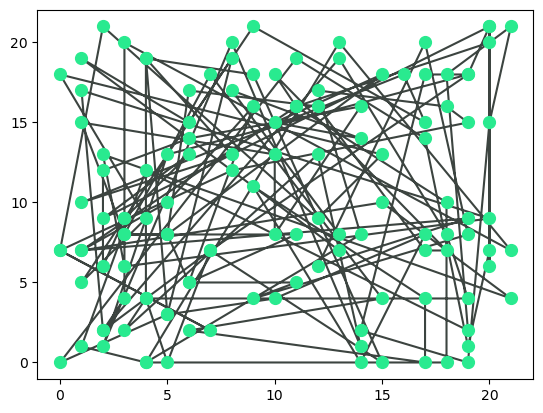

Total distance: 1302.306





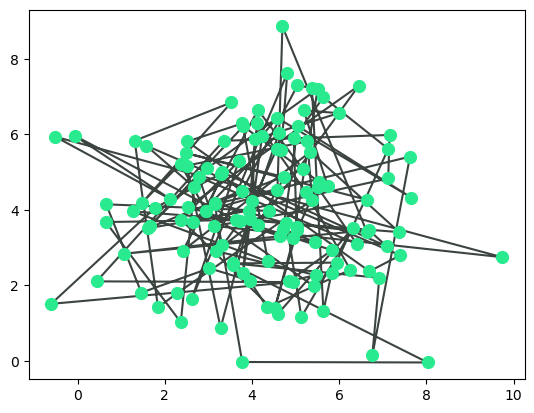

Total distance: 369.3961





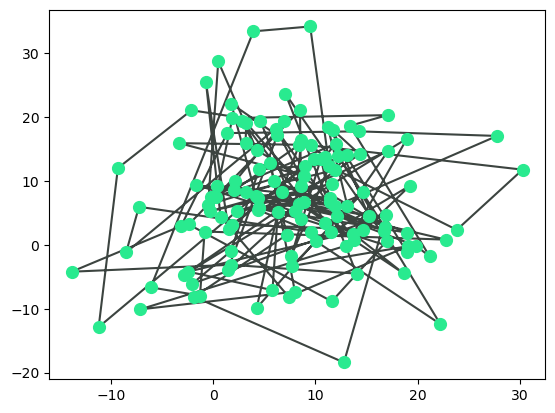

Total distance: 1777.226





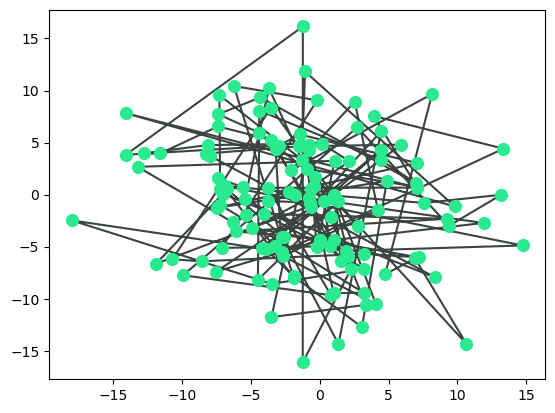

Total distance: 1230.3169





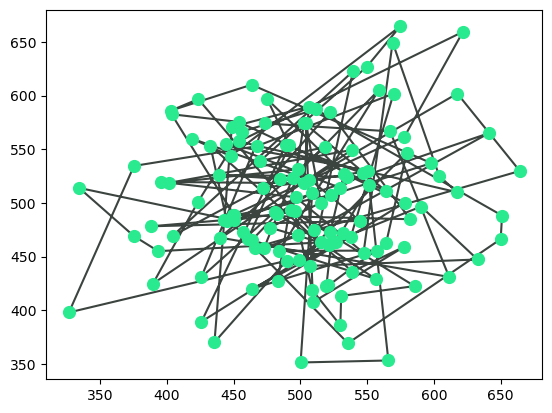

Total distance: 12400.5551





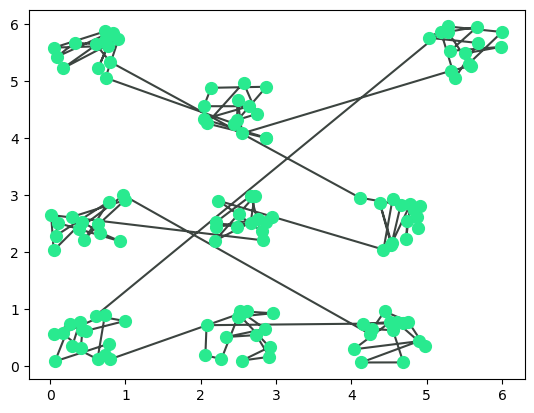

Total distance: 90.2293





In [9]:
for p in generate_point_arrays(2**7):
    res, total_distance = SimulatedAnnealing(p, .95, 2**10, 20000, NeighbourSelection.ARBITRARY_SWAP).run()
    draw_point_array(p, res)
    print(f"Total distance: {round(total_distance, 4)}", end="\n\n\n\n")

b) Badanie wpływu sposobu generacji sąsiedniego stanu (consecutive swap vs. arbitrary swap) oraz funkcji zmiany temperatury na zbieżność procesu optymalizacji

Weryfikacja dokładności dla $n = 8$ za pomocą obliczenia dokładnego wyniku (brute force).

In [10]:
class TSP:
    def __init__(self, points):
        self.points = points
        
    def brute_force(self):
        solution, distance = None, math.inf
        
        for p in permutations(np.arange(len(self.points))):
            d = 0.0
            for i, j in [(p[i], p[(i + 1) % len(p)]) for i in range(len(p))]:
                p1, p2 = self.points[i], self.points[j]
                d += ((p2.x - p1.x)**2 + (p2.y - p1.y)**2)**.5
                
            if d < distance:
                solution, distance = p, d
                
        return solution, distance
        

In [20]:
P = generate_point_arrays(2**3)
neighbour_selections = [NeighbourSelection.ARBITRARY_SWAP, NeighbourSelection.CONSECUTIVE_SWAP]
gammas = [.99, .95, .9]
temperatures = [1, 5, 10, 16, 100]
max_iterations = [50, 100, 500]

for i, p in enumerate(P):
    solution, distance = TSP(p).brute_force()
    results = { "Gamma": [], "Neighbour selection": [], "Initial temp.": [], "Max iter.": [], "Abs. difference": [], "Difference %": [] }
    
    for gamma in gammas:
        for neighbour_selection in neighbour_selections:
            for temperature in temperatures:
                for max_iter in max_iterations:
                    _, dist = SimulatedAnnealing(p, gamma, temperature, max_iter, neighbour_selection).run()
                    results["Gamma"].append(gamma)
                    results["Neighbour selection"].append(
                        "Arbitrary swap" if neighbour_selection == NeighbourSelection.ARBITRARY_SWAP else "Consecutive swap"
                    )
                    results["Initial temp."].append(temperature)
                    results["Max iter."].append(max_iter)
                    results["Abs. difference"].append(np.abs(distance - dist))
                    results["Difference %"].append(np.abs(distance - dist) / distance * 100)
    
    if i > 0:
        print(pd.DataFrame(data=results), end="\n\n\n\n")
    else:
        print(pd.DataFrame(data=results).to_string(), end="\n\n\n\n")

    Gamma Neighbour selection  Initial temp.  Max iter.  Abs. difference  Difference %
0    0.99      Arbitrary swap              1         50     6.502815e-01  4.840573e+00
1    0.99      Arbitrary swap              1        100     1.776357e-15  1.322287e-14
2    0.99      Arbitrary swap              1        500     0.000000e+00  0.000000e+00
3    0.99      Arbitrary swap              5         50     4.473026e-02  3.329636e-01
4    0.99      Arbitrary swap              5        100     1.679144e+00  1.249923e+01
5    0.99      Arbitrary swap              5        500     6.305167e-01  4.693447e+00
6    0.99      Arbitrary swap             10         50     2.808662e+00  2.090715e+01
7    0.99      Arbitrary swap             10        100     5.567264e-01  4.144166e+00
8    0.99      Arbitrary swap             10        500     0.000000e+00  0.000000e+00
9    0.99      Arbitrary swap             16         50     1.236068e+00  9.201057e+00
10   0.99      Arbitrary swap             1

Analizując powyższe zestawy danych można dojśc do kilku wniosków:
- najbardziej oczywistym spostrzeżeniem jest wpływ ilości iteracji na zbieżność wyników - im więcej, tym wynik jest bardziej dokładny;
- zazwyczaj lepiej wypada zamiana sąsiadów niż dwóch losowych punktów;
- dopasowanie współczynnika $\gamma$ (chłodzenie temperatury) oraz temperatury początkowej może mieć relatywnie duże znaczenie na wygenerowane rozwiązanie.

## Zadanie 2. Obraz binarny.

Wygeneruj losowy obraz binarny o rozmiarze $n \times n$ i wybranej gęstości $\delta$ czarnych punktów $\delta = 0.1, 0.3, 0.4$. Korzystając z różnego typu sąsiedztwa (4-sąsiadów, 8-sąsiadów, 8-16-sąsiadów) zaproponuj funkcję energii (np. w bliskiej odległości te same kolory przyciągają się, a w dalszej odpychają się) i dokonaj jej minimalizacji za pomocą algorytmu symulowanego wyżarzania. W jaki sposób można generować stany sąsiednie? Jak róż nią się uzyskane wyniki w zależności od rodzaju sąsiedztwa, wybranej funkcji energii i szybkości spadku temperatury?

In [9]:
deltas = [.1, .3, .4]

class SimulatedAnnealingImage:
    def __init__(self, initial_solution, gamma, initial_T, max_iterations):
        self.initial_solution = initial_solution
        self.gamma = gamma
        self.T = initial_T
        self.max_iterations = max_iterations

    def run(self):
        state, state_energy = copy.copy(self.initial_solution), self.__E(self.initial_solution)
        solution, solution_energy = copy.copy(state), state_energy
        
        # fig, ax = plt.subplots()
        # ims = []
        
        for c in range(self.max_iterations):
            # if self.T <= 10**-6:
            #     break

            # Progress bar
            # if c % 20000 == 0:
            #     p = c / self.max_iterations
            #     if p > 0:
            #         print(f"\r[{'=' * math.ceil((25 * c / p))}{' ' * math.floor((25 * (1 - p)))}]", end='')
            #     else:
            #         print(f"\r[{' ' * 25}]", end='')

            i, j = np.random.randint(n, size=2)
            neighbour = self.neighbour(state, (i, j))
            local_state_energy = np.abs(self.E(state, (i, j)) - self.E(state, neighbour))
            state[i][j], state[neighbour[0]][neighbour[1]] = state[neighbour[0]][neighbour[1]], state[i][j]
            local_new_state_energy = np.abs(self.E(state, (i, j)) - self.E(state, neighbour))
            # print(local_state_energy, local_new_state_energy)
            if self.P(local_new_state_energy, local_state_energy) >= np.random.uniform(0, 1):
                # print(i, j, neighbour[0], neighbour[1], local_new_state_energy - local_state_energy)
                # if state_energy < solution_energy:
                #     solution, solution_energy = copy.copy(state), state_energy
                pass
            else:
                state[i][j], state[neighbour[0]][neighbour[1]] = state[neighbour[0]][neighbour[1]], state[i][j]
                
            if c % 100 == 0:
                self.T *= self.gamma
            # if c % 10000 == 0:        
            #     self.__add_frame(state, ax, ims, c)

        # print(f"\r{' ' * 50}")
        return state, self.__E(state)

    def E(self, state, pos):
        if state[pos[0]][pos[1]] != 0:
            return 0
        return self.distance(pos)

    def __E(self, state):
        n, acc = len(state), 0
        for i in range(n):
            for j in range(n):
                acc += self.E(state, (i, j))

        return acc

    def distance(self, p):
        n = len(self.initial_solution)

        # Upper left
        if 0 <= p[0] < n // 2 and 0 <= p[1] < n // 2:
            p0 = (0, 0)
        # Upper right
        elif n // 2 <= p[0] < n and 0 <= p[1] < n // 2:
            p0 = (n - 1, 0)
        # Bottom right
        elif n // 2 <= p[0] < n and n // 2 <= p[1] < n:
            p0 = (n - 1, n - 1)
        # Bottom left
        else:
            p0 = (0, n - 1)

        return math.ceil(((p0[0] - p[0]) ** 2 + (p0[1] - p[1]) ** 2) * .5)

    def neighbour(self, state, pos):
        neighbours = []
        deltas = [(0, -1), (1, 0), (0, 1), (-1, 0)]
        n = len(state)

        i, j = np.random.randint(n, size=2)
        for di, dj in deltas:
            if 0 <= pos[0] + di < n and 0 <= pos[1] + dj < n and state[pos[0] + di][pos[1] + dj] != state[pos[0]][pos[1]]:
                neighbours.append((pos[0] + di, pos[1] + dj))

        return neighbours[np.random.randint(len(neighbours))] if len(neighbours) > 0 else pos

    def P(self, new_state_cost, state_cost):
        if new_state_cost < state_cost:
            return 1
        return np.exp((state_cost - new_state_cost) / self.T)
    
    @staticmethod
    def __add_frame(state, ax, ims, c):
        if c == 0:
            ax.imshow(state, cmap="gray", vmin=0, vmax=1, interpolation="none")
        im = ax.imshow(state, cmap="gray", vmin=0, vmax=1, interpolation="none", animated=True)
        ims.append([im])


Obraz generuję za pomocą 4 sąsiadów góra-dół-lewo-prawo, funkcją energii jest odległość od najbliższego dla danego punktu rogu obrazu binarnego.

a) $n = 32$

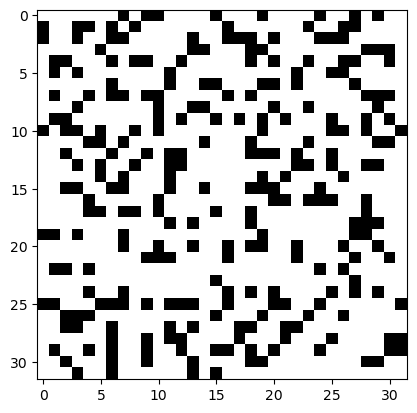

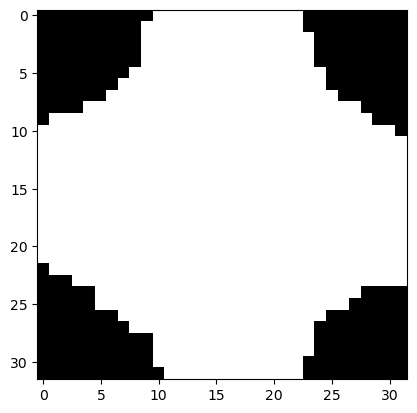

In [10]:
n = 32

image = np.random.uniform(100, size=(n, n))
for i in range(n):
    for j in range(n):
        image[i][j] = 0 if image[i][j] < 30 else 1

plt.imshow(image, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .99, 100, 200000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

b) $n = 128$

In [ ]:
n = 128

image = np.random.uniform(size=(n, n))
for i in range(n):
    for j in range(n):
        image[i][j] = 0 if image[i][j] < deltas[2] else 1
        
plt.imshow(image, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

Temperatura $T$ = 100, współczynnik spadku temperatury $\gamma$ = 0.99

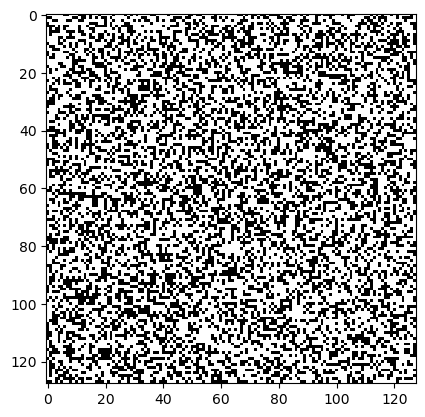

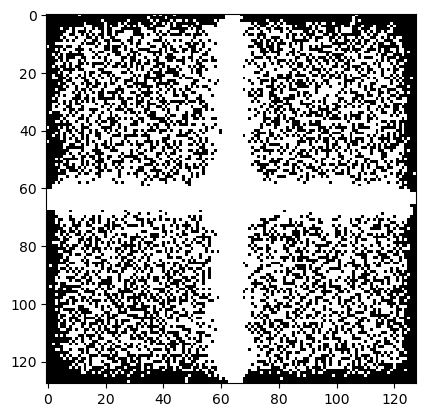

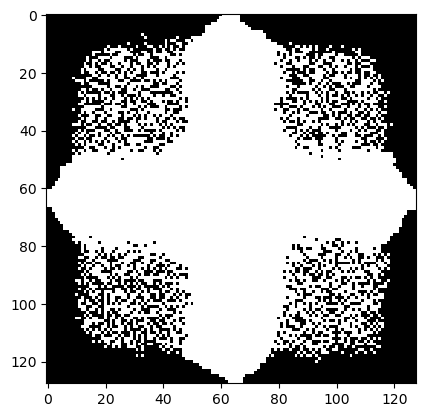

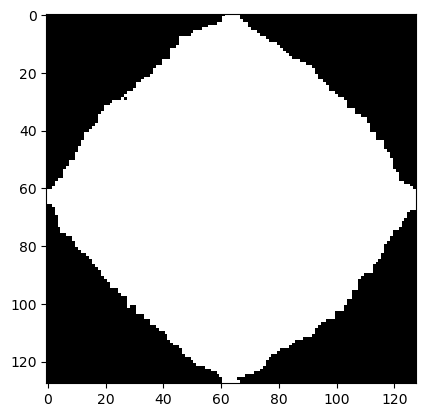

In [13]:
solution, energy = SimulatedAnnealingImage(image, .99, 100, 200000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .99, 100, 500000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .99, 100, 1000000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

Temperatura $T$ = 100, współczynnik spadku temperatury $\gamma$ = 0.95

In [ ]:
solution, energy = SimulatedAnnealingImage(image, .95, 100, 200000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .95, 100, 500000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .95, 100, 1000000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

c) $n = 256$

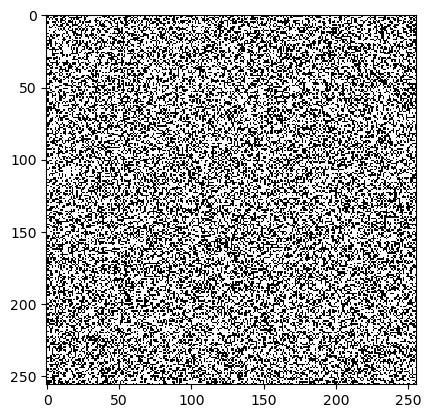

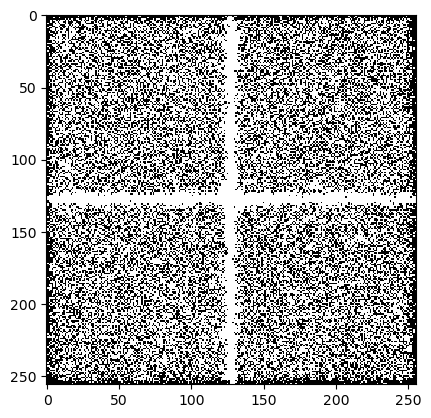

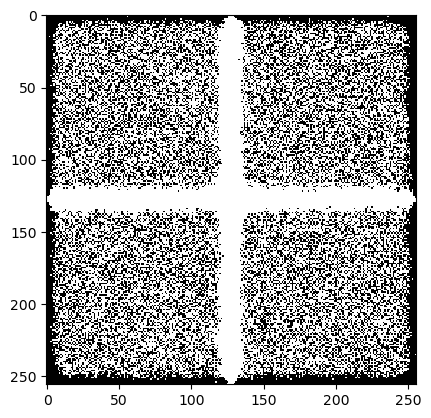

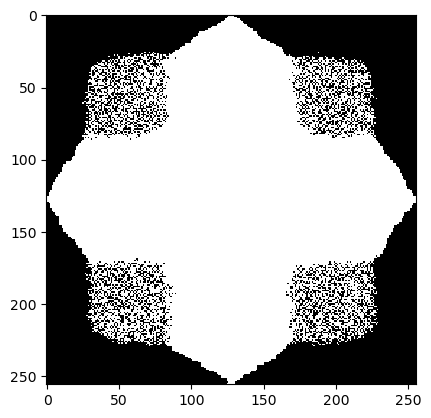

In [14]:
n = 256

image = np.random.uniform(size=(n, n))
for i in range(n):
    for j in range(n):
        image[i][j] = 0 if image[i][j] < deltas[2] else 1

plt.imshow(image, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .99, 100, 500000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .99, 100, 1000000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .99, 100, 5000000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

d) = $n = 512$

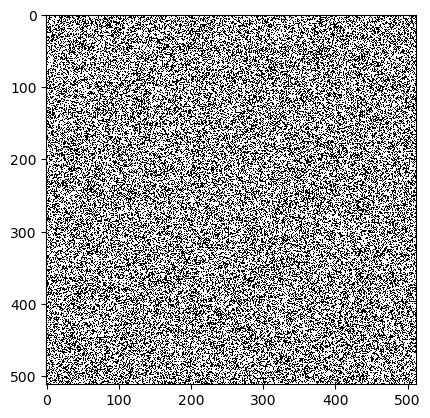

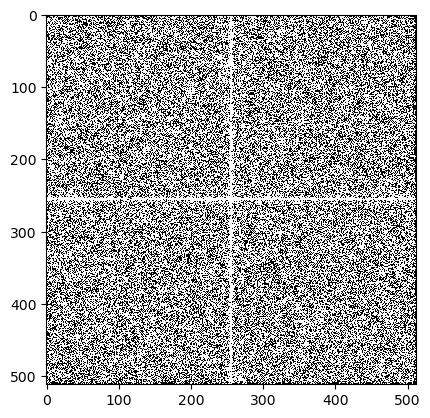

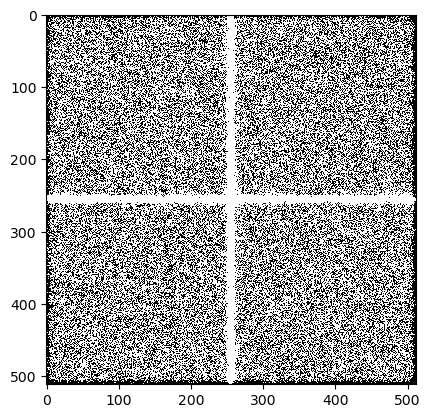

/tmp/ipykernel_11189/279085541.py:97: RuntimeWarning: overflow encountered in divide
  return np.exp((state_cost - new_state_cost) / self.T)


KeyboardInterrupt: 

In [15]:
n = 512

image = np.random.uniform(size=(n, n))
for i in range(n):
    for j in range(n):
        image[i][j] = 0 if image[i][j] < deltas[2] else 1

plt.imshow(image, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .99, 100, 1000000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .99, 100, 3000000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

solution, energy = SimulatedAnnealingImage(image, .99, 100, 10000000).run()
plt.imshow(solution, cmap="gray", vmin=0, vmax=1, interpolation="none")
plt.show()

## Zadanie 3. Sudoku.

Napisz program poszukujący rozwiązania łamigłówki `Sudoku` za pomocą symulowanego wyżarzania. Plansza $9 \times 9$ ma zostać wczytana z pliku tekstowego, w którym pola puste zaznaczone są znakiem `x`. Jako funkcję kosztu przyjmij sumę powtórzeń cyfr występu- jących w wierszach bloku $9 \times 9$, kolumnach bloku $9 \times 9$ oraz blokach $3 \times 3$. Zaproponuj metodę generacji stanu sąsiedniego. Przedstaw zależność liczby iteracji algorytmu od liczby pustych miejsc na planszy. Czy Twój program jest w stanie znaleźć poprawne rozwiązanie dla każdej z testowanych konfiguracji wejściowych?

In [1]:
class SimulatedAnnealingSudoku:
    def __init__(self, initial_solution, gamma, initial_T, max_iterations):
        self.S = copy.copy(initial_solution)
        self.initial_solution = copy.copy(initial_solution)
        self.gamma = gamma
        self.T = initial_T
        self.max_iterations = max_iterations
        
        n = len(initial_solution)
        for i in range(n):
            digits = []
            for j in range(n):
                if self.S[i][j] > 0:
                    digits.append(self.S[i][j])
            for j in range(n):
                if self.S[i][j] > 0:
                    continue
                
                while True:
                    self.initial_solution[i][j] = np.random.randint(1, n + 1)
                    if self.initial_solution[i][j] not in digits:
                        break
                digits.append(self.initial_solution[i][j])
        
    def run(self):
        state, state_energy = copy.copy(self.initial_solution), self.E(self.initial_solution)
        solution, solution_energy = copy.copy(state), state_energy
        
        for _ in range(self.max_iterations):
            if solution_energy == 0:
                break
            
            while True:
                i, j = np.random.randint(0, 9, size=2)
                if self.S[i][j] == 0:
                    break
                
            ni, nj = self.neighbour(state, (i, j))
            state[i][j], state[ni][nj] = state[ni][nj], state[i][j]
            new_state_energy = self.E(state)
            
            if self.P(new_state_energy, state_energy) >= np.random.uniform(0, 1):
                state_energy = new_state_energy
                if state_energy < solution_energy:
                    solution, solution_energy = copy.copy(state), state_energy
            else:
                state[i][j], state[ni][nj] = state[ni][nj], state[i][j]
                
        return solution, solution_energy

    def E(self, state):    
        energy, n = 0, len(state)
        
        for k in range(n):
            # row-wise
            row = np.zeros(n + 1)
            # column-wise
            col = np.zeros(n + 1)
            # block-wise
            block = np.zeros(n + 1)
        
            for i in range(n):
                row[state[k][i]] += 1
                col[state[i][k]] += 1
            
            si, sj = 3 * (k // 3), 3 * (k % 3)
            for i in range(si, si + 3):
                for j in range(sj, sj + 3):
                    block[state[i][j]] += 1
              
            for i in range(1, n + 1):
                energy += max(row[i] + col[i] + block[i] - 3, 0)
            
        return energy

    def neighbour(self, state, pos):
        si, sj = 3 * (pos[0] // 3), 3 * (pos[1] % 3) 
        c = 0
        while True:
            i, j = np.random.randint(si, si + 3), np.random.randint(sj, sj + 3)
            c += 1
            if c >= 100:
                return pos
            if (i, j) != pos and self.S[i][j] == 0:
                return i, j
            
        return None

    def P(self, new_state_cost, state_cost):
        if new_state_cost < state_cost:
            return 1
        return np.exp((state_cost - new_state_cost) / self.T)
    
    
def load_sudoku_from_file(path):
    """
    Whitespace seperated list
    """
    
    with open(path) as file:
        puzzle = np.empty((9, 9))
        
        for i, line in enumerate(file.readlines()):
            digits = [int(d) if d != 'x' else 0 for d in line.strip().split()]
            for j, d in enumerate(digits):
                puzzle[i][j] = d
                
        return puzzle
    
    return None


In [7]:
_ = 0
sudoku_puzzle = np.array([
    [2, _, 6,    _, 8, _,    _, _, _],
    [_, _, _,    _, _, _,    _, _, 3],
    [1, _, _,    _, _, 7,    2, 4, _],
    
    [4, _, _,    _, _, 2,    1, 5, _],
    [_, _, _,    _, _, _,    9, _, _],
    [_, 2, _,    7, _, _,    _, _, _],
    
    [_, _, _,    _, _, 5,    _, _, 9],
    [_, _, 1,    6, _, _,    5, 3, _],
    [3, _, _,    _, _, _,    _, _, 7]
])
SimulatedAnnealingSudoku(sudoku_puzzle, .99, 10, 1000000).run()

(array([[2, 7, 6, 1, 8, 3, 9, 3, 4],
        [2, 5, 9, 8, 6, 4, 6, 5, 3],
        [1, 8, 5, 7, 9, 7, 2, 4, 1],
        [4, 5, 6, 9, 3, 2, 1, 5, 1],
        [6, 4, 7, 8, 1, 3, 9, 7, 8],
        [9, 2, 3, 7, 5, 4, 8, 2, 6],
        [7, 3, 9, 4, 2, 5, 5, 8, 9],
        [4, 8, 1, 6, 7, 1, 5, 3, 9],
        [3, 1, 2, 6, 2, 6, 4, 8, 7]]),
 21.0)

Algorytm symulowanego wyżarzania do rozwiązywania Sudoku powinien sobie poradzić z każdą planszą możliwą do rozwiązania, ustawiając odpowiednie parametry. Algorytm generuje stan sąsiedni za pomocą znalezienia losowego sąsiada w obrębie bloku, jeśli nie ma odpowiedniego kandydata zwraca pozycję przekazaną w argumencie. Tablica `sudoku_puzzle` posiada bardzo trudny poziom trudności, dla liczby iteracji równej $10^6$ nie potrafiłem znaleźć rozwiązania w kilku osobnych wywołaniach.